In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50, InceptionV3, InceptionResNetV2, Xception
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.ensemble import ExtraTreesClassifier
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

In [2]:
def load_and_preprocess_images(data_dir, target_size=(224, 224), augmentation=True):
    images = []
    labels = []

    # Create an ImageDataGenerator for augmentation (outside the loop)
    if augmentation:
        datagen = ImageDataGenerator(
            rotation_range=20,  # Random rotation up to 20 degrees
            zoom_range=0.2,  # Random zoom
            horizontal_flip=True,  # Random horizontal flip
            vertical_flip=True,  # Random vertical flip
        )
    else:
        datagen = None

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith(".jpg"):
                    image_path = os.path.join(label_dir, filename)
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, target_size)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
                    
                    if datagen:
                        # Apply data augmentation if enabled
                        image = datagen.flow(np.array([image]), batch_size=1)[0].astype('uint8')[0]

                    images.append(image)

                    # Extract label based on the subdirectory (Autistic or Non_Autistic)
                    if label.lower() == "autistic":
                        label_value = 1  # Autistic
                    elif label.lower() == "non_autistic":
                        label_value = 0  # Non-Autistic
                    else:
                        label_value = -1  # Handle other cases
                    labels.append(label_value)

    return images, labels

Number of images: 2940


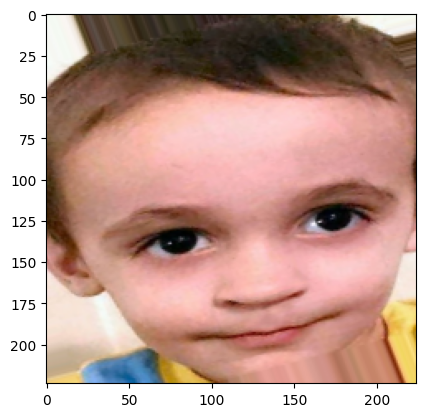

In [3]:
data_dir = "Dataset\AutismDataset\consolidated"

# Load and preprocess images and labels
images, labels = load_and_preprocess_images(data_dir, augmentation=True)

num_images = len(images)
print(f"Number of images: {num_images}")
image = images[0]

# Plot the image
plt.imshow(image)
plt.show()

# Ensure that the number of images and labels is consistent
if len(images) != len(labels):
    raise ValueError("Number of images and labels do not match.")

# Create a DataFrame with unique identifiers by appending labels to filenames
autistic_filenames = [f"autistic_{i:04d}.jpg" for i in range(1, len(images) // 2 + 1)]
non_autistic_filenames = [f"non_autistic_{i:04d}.jpg" for i in range(1, len(images) // 2 + 1)]

# Combine the lists of filenames and labels
all_filenames = autistic_filenames + non_autistic_filenames
all_labels = labels

# Create the DataFrame
df = pd.DataFrame({'Image_File': all_filenames, 'Label': all_labels})


In [4]:
num_classes = 2  # Autistic and Non_Autistic

# Create the DataFrame
df = pd.DataFrame({'Image': images, 'Label': labels})

# Split the data into training, validation and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

# Extract the images and labels for each set
X_train, y_train = np.array(list(train_df['Image'])), np.array(list(train_df['Label']))
X_val, y_val = np.array(list(val_df['Image'])), np.array(list(val_df['Label']))
X_test, y_test = np.array(list(test_df['Image'])), np.array(list(test_df['Label']))

# Normalize the image data
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [5]:
def fine_tune_and_extract_features(model_class, data, num_classes, input_shape):
    # Load the pre-trained model without the top layers
    base_model = model_class(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add new layers
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Define the new model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    n_folds = 2
    kfold = KFold(n_splits=n_folds, shuffle=True)

    # Train the model
    for train, val in kfold.split(X_train, y_train):
        model.fit(X_train[train], y_train[train], epochs=5, validation_data=(X_train[val], y_train[val]), callbacks=[early_stopping])

    # model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Unfreeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = True

    # Continue training
    model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Extract features
    features = model.predict(data)

    return features

# Instantiate the pre-trained models
models = [VGG19, ResNet50, VGG16, InceptionV3, InceptionResNetV2, Xception]
input_shape = (224, 224, 3)

In [7]:
# Iterate through the pre-trained models and extract features
# Extract features from training and test data
# Initialize lists to store results

y_train_indices = np.argmax(y_train, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Iterate over each pre-trained model
for model_class in models:

    # Extract features
    train_features = fine_tune_and_extract_features(model_class, X_train, num_classes, input_shape)
    print(f"Train {model_class.__name__} Done")
    test_features = fine_tune_and_extract_features(model_class, X_test, num_classes, input_shape)
    print(f"Test {model_class.__name__} Done")
    
    flattened_train_features = train_features.reshape(train_features.shape[0], -1)
    flattened_test_features = test_features.reshape(test_features.shape[0], -1)

    pca = PCA(n_components=2)
    pca_train_features = pca.fit_transform(flattened_train_features)
    pca_test_features = pca.transform(flattened_test_features)

    print(f"PCA {model_class.__name__} Done")
    # Train SVM on PCA features and evaluate
    svm_classifier = SVC(C=0.1, kernel='linear', gamma=0.1)
    svm_classifier.fit(pca_train_features, y_train_indices)
    y_test_pred = svm_classifier.predict(pca_test_features)
    
    # Print confusion matrix and classification report
    print(f"Model {model_class.__name__}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_indices, y_test_pred))
    print("Classification Report:")
    print(classification_report(y_test_indices, y_test_pred))


# # Print out the accuracies before and after PCA for each model
# for i, model_class in enumerate(models):
#     print(f"Model {model_class.__name__}: Accuracy before PCA = {accuracies_before_pca[i]}, Accuracy after PCA = {accuracies_after_pca[i]}")

Epoch 1/5
 7/28 [======>.......................] - ETA: 34s - loss: 6.5428 - accuracy: 0.4688

In [ ]:
# # Feature selection
# selectKBest = SelectKBest(score_func=chi2, k='all')
# X_train_selected = selectKBest.fit_transform(all_train_features_scaled, y_train)

# etc_model = ExtraTreesClassifier(random_state=42)
# etc_model.fit(all_train_features_scaled, y_train)


# # Extract the feature importances and select features
# feature_importance = etc_model.feature_importances_
# num_features_to_select = int(all_train_features_scaled.shape[1] * 0.5)
# selected_features = np.argsort(feature_importance)[-num_features_to_select:]
# X_train_selected = all_train_features_scaled[:, selected_features]

In [ ]:
# y_train_indices = np.argmax(y_train, axis=1)

# # Train the SVM classifier
# svm_classifier = SVC(C=0.1, kernel='linear', gamma=0.1)
# svm_classifier.fit(X_train_selected, y_train_indices)

SVC(C=0.1, gamma=0.1, kernel='linear')

In [ ]:
# all_test_features = []

# # Iterate through the pre-trained models and extract features from the test data
# for model_class in models:
#     base_model = model_class(weights='imagenet', include_top=False, input_shape=input_shape)
#     test_features = base_model.predict(X_test)
#     flattened_test_features = test_features.reshape(test_features.shape[0], -1)
#     all_test_features.append(flattened_test_features)
# all_test_features = np.concatenate(all_test_features, axis=1)

# # Scale and select features from the test data
# all_test_features_scaled = scaler.transform(all_test_features)
# Extract features from the test data using ExtraTrees model

# Select features from the test data based on the feature importances
# X_test_selected = all_test_features_scaled[:, selected_features]

# # Evaluate the model
# y_test_pred = svm_classifier.predict(X_test_selected)

# y_test_indices = np.argmax(y_test, axis=1)
# # Generate a classification report to evaluate the model's performance on the test data
# test_report = classification_report(y_test_indices, y_test_pred)
# print(f"Testing Classification Report: \n{test_report}")

19/19 [==============================] - 21s 1s/step


ValueError: X has 340480 features, but StandardScaler is expecting 12 features as input.